# Prediction of Car prices

Project goal is to find a regression model that accurately predicts the sale price of preowned cars using a number of car features. Data set is scraped from an online site used to resale pre-owned cars.

### 0. Library imports

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [4]:
# Data has been scraped from online market places 
df = pd.read_csv("volvo_cars_3737_sample.csv").drop(columns="Unnamed: 0")

### 1.1 Data cleaning: Cleaning format

In [5]:
df.head(5)
df = df.dropna(thresh=10)

In [6]:
# 1) Set price that is monthly (leasing) to NaN - only interested in actual car price
# 2) remove ccy (SEK) and turn prices into integers
df["price"] = df["price"].apply(lambda x: np.nan if str(x).lower().find("mån") > -1 else x)
df["price"] = df["price"].apply(lambda x: int(str(x).replace(" kr", "").replace(" ", "")) if str(x).replace(" kr", "").replace(" ", "").isnumeric() else x)

#### FUEL TYPE ####
# Reclassify different models
df.fuel_type = df.fuel_type.replace(to_replace=["Bensin/Elhybrid", "Bensin/Laddhybrid"], value="bensin hybrid")
df.fuel_type = df.fuel_type.replace(to_replace=["Diesel/Elhybrid", "Diesel/Laddhybrid"], value="diesel hybrid")

#### MODEL YEAR ####
# drop models before 2017
df = df.drop(index = df.loc[df.model_year < 2017].index)

#### COLOR ####
# replace "light"/"medium" color shades with their color
df.color = df.color.replace(to_replace=["Mblå", "Lblå"], value="Blå").replace(to_replace=["Mgrå", "Lgrå"], value="Grå").replace(to_replace=["Mbrun", "Lbrun"], value="Brun")

#### GEAR BOX ####
# replace strings with numbers
df.drive_wheel = df.drive_wheel.replace("Fyrhjulsdrift", 4).replace("Tvåhjulsdrift", 2)

#### KM DRIVEN ####
# 1) replace missing data with NaN, 2) convert datapoints to floats
df.km_driven = df.km_driven.replace("(Uppgift saknas)", np.nan).str.replace(" ", "")
df.km_driven = df.km_driven.apply(lambda x: float(x) if x != np.nan else x)

#### HORSE POWER ####
def find_horse_power(x):
    try: 
        hp = re.search(r"\d+(?= hk)", str(x))
        hp = hp[0]
        return hp
    except:
        return np.nan

df["horse_power"] = df["horse_power"].apply(lambda x: find_horse_power(x))
df.horse_power = df.horse_power.astype(int)

#### TOP SPEED ####
df.top_speed = df.top_speed.str.replace(" km/h", "").astype(int)

#### ENGINE SIZE ####
df.engine_size = df.engine_size.str.replace(" cc", "")
df.engine_size = df.engine_size.apply(lambda x: float(x) if x != np.nan else x)

#### FUEL CONSUMPTION ####
# Liters per 100 km
df.fuel_consumption = df.fuel_consumption.str.replace(" l/100km", "")
df.fuel_consumption = df.fuel_consumption.apply(lambda x: float(x) if x != np.nan else x)


### 1.2 Data cleaning: Imputing values and dropping NaN / non-relevant values

In [7]:
df = df.drop(columns = ["image_url", "url", "brand", "model"])
df = df.drop(index = df.loc[(df.color == "Gul") | (df.color == "Flerf") | (df.color == "Grön")].index)
df = df.dropna(subset=["price", "gear_box", "engine_size", "fuel_consumption"]).reset_index(drop=True)
df = df.drop(index = df.loc[(df.model_year == 2023)].index)
df = df.drop(index = df.loc[(df.price < 10000)].index)

In [8]:
# there are still NaN values in km_driven - these will be imputed later
df.isna().sum()

price                  0
fuel_type              0
model_year             0
color                  0
gear_box               0
num_seats              0
drive_wheel            0
km_driven           1316
horse_power            0
top_speed              0
engine_size            0
fuel_consumption       0
dtype: int64

### 2. Exploratoty Data Analysis

<Axes: >

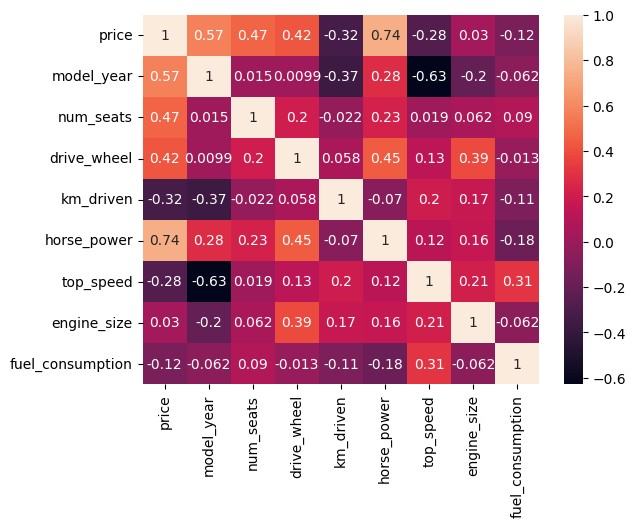

In [9]:
# negative correlation between price and top_speed is a bit surprising, other correlations are in line with intutive reasoning
sns.heatmap(df.corr(), annot=True)

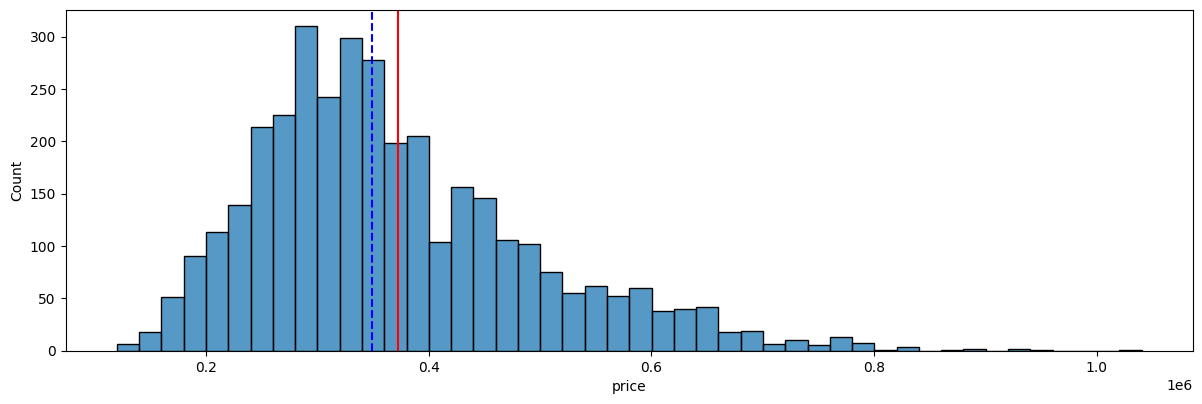

In [10]:
# Disitribution of the target variable price, median and average between 300-400 kSEK

fig, ax = plt.subplots(1,1, figsize=(12,4))
plt.tight_layout()

sns.histplot(data=df, x="price")

average_price = df["price"].mean()
median_price = df["price"].median()

ax.axvline(average_price, color='r', linestyle='-', label='Average Price')
ax.axvline(median_price, color='b', linestyle='--', label='Median Price')

<Axes: xlabel='fuel_consumption', ylabel='price'>

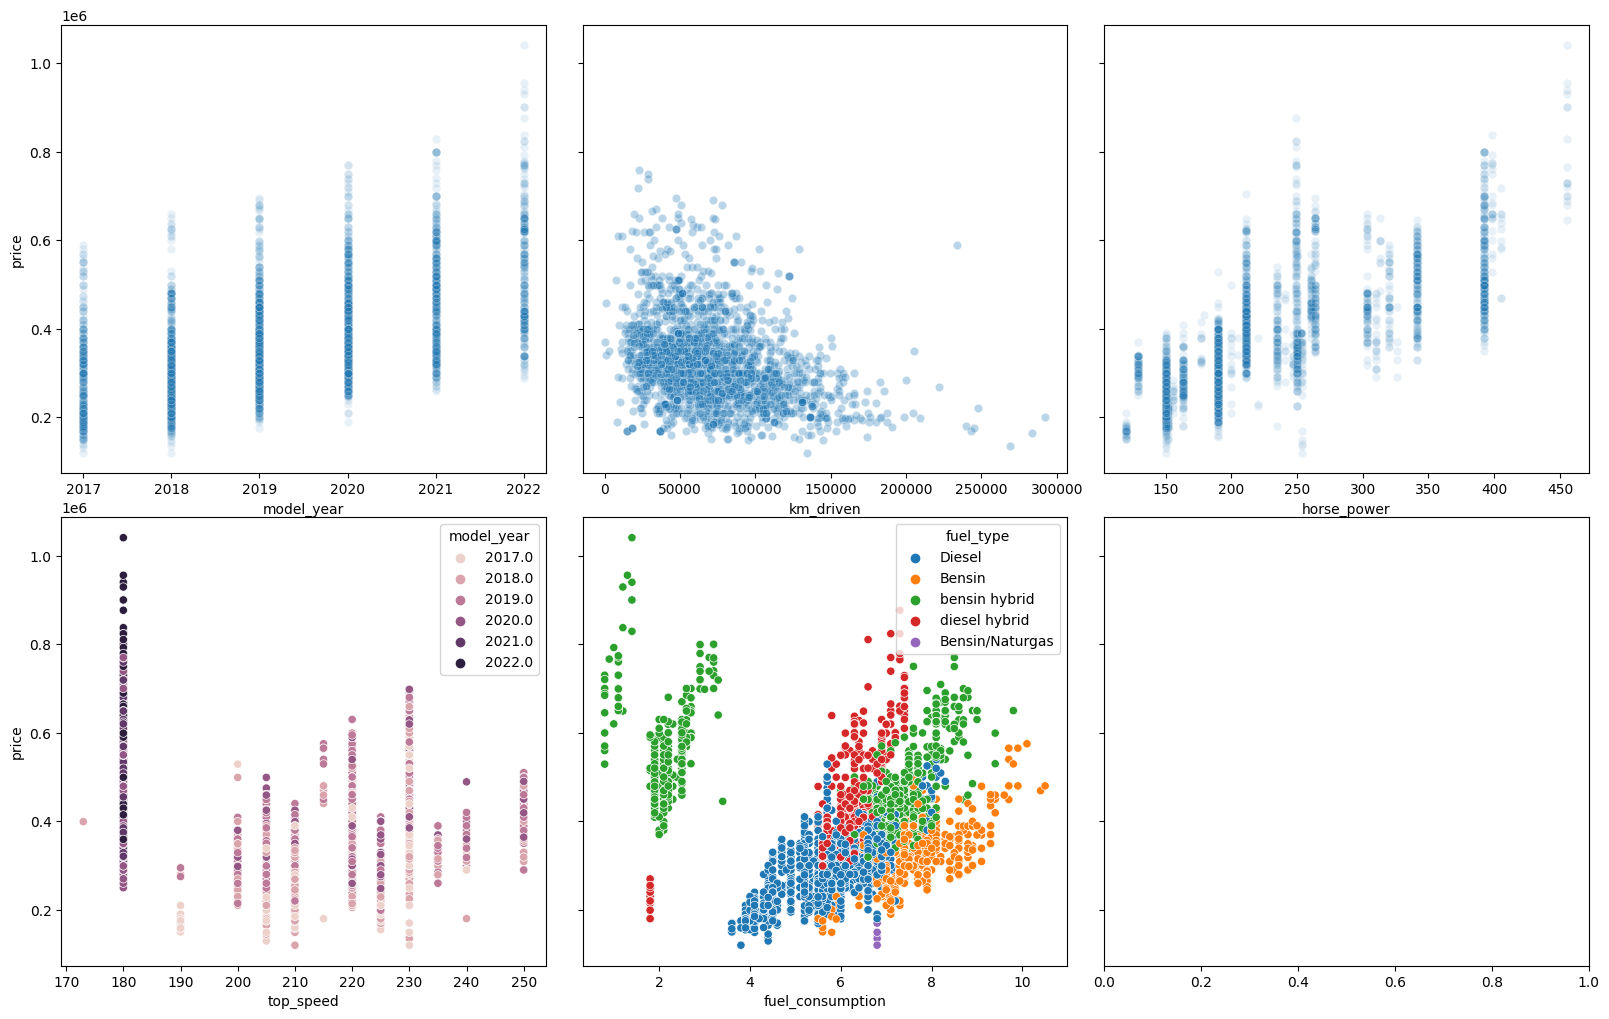

In [11]:
# neg corr between top speed/price seems to be caused by model_year feature

fig, ax = plt.subplots(2,3, figsize=(16,10), sharey=True)
plt.tight_layout()

sns.scatterplot(data=df, x="model_year", y="price", alpha=0.1, ax = ax[0][0])
sns.scatterplot(data=df.loc[df.km_driven < 300000], x="km_driven", y="price", alpha=0.3, ax = ax[0][1])
sns.scatterplot(data=df, x="horse_power", y="price", alpha=0.1, ax = ax[0][2])

sns.scatterplot(data=df, x="top_speed", y="price", ax = ax[1][0], hue="model_year")
sns.scatterplot(data=df, x="fuel_consumption", y="price", hue="fuel_type",ax = ax[1][1])


<Axes: xlabel='engine_size', ylabel='price'>

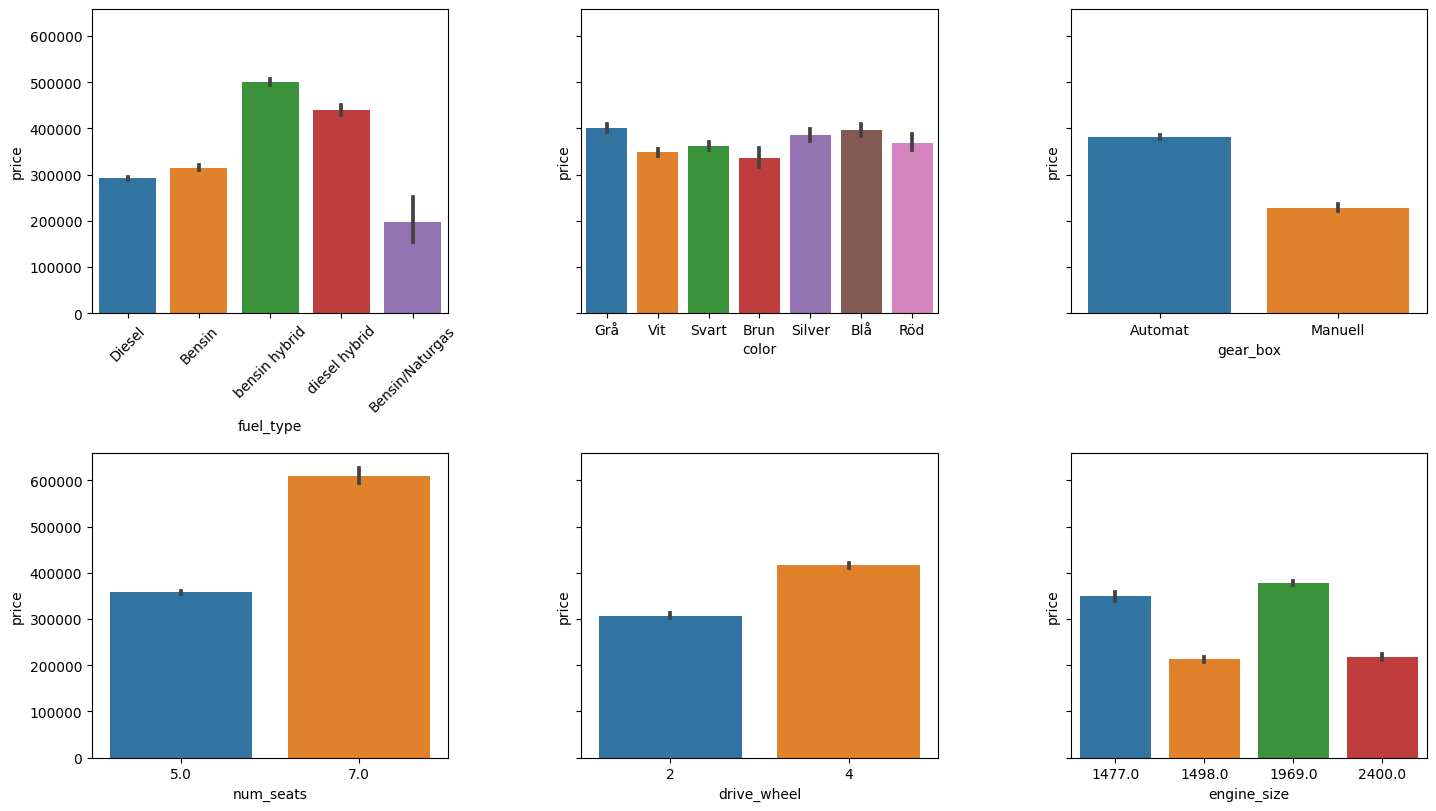

In [12]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(16,10), sharey=True)
plt.tight_layout(pad=8)


sns.barplot(data=df, x="fuel_type", y="price", ax = ax1)
ax1.tick_params(labelrotation=45, axis="x")
sns.barplot(data=df, x="color", y="price", ax = ax2)
sns.barplot(data=df, x="gear_box", y="price", ax = ax3)

sns.barplot(data=df, x="num_seats", y="price", ax = ax4)
sns.barplot(data=df, x="drive_wheel", y="price", ax = ax5)
sns.barplot(data=df, x="engine_size", y="price", ax = ax6)


### 3. Inital Regressions and model selection

In [13]:
# custom_imputer to handle the missing values in the km_driven column (see appendix for example)

class custom_imputer():
    # initializer 
    def __init__(self, group_column):
        self.group_column = group_column
        
    def fit(self, X, y = None):
        return self
    
    # Imputor
    def transform(self, X, y = None):
        for col in X.columns:                             # For each of the features passed through custom_imputor...
            if col != self.group_column:                  # ... except for the group_column ...
                X[col]= X.apply(lambda x: x[col]          # ... keep value ... 
                                        if x[col] > 0     # ... if value is > 0, i.e. if value is not NaN ...
                                        else (X.groupby(self.group_column)[col].mean()[x[self.group_column]]          # However, if value is NaN, take the mean value of the data points that have the same category in the group_column...
                                              if X.groupby(self.group_column)[col].mean()[x[self.group_column]] > 0   # ... If that mean value in itself is not equal to NaN (i.e. that there are data points with values in that category)
                                              else X.groupby(self.group_column)[col].mean().mean()),                  # However if there are no actual values in that category, impute mean of the whole dataset regardless of category in grouping column
                                        axis=1)        
            else: 
                continue
        return X.drop(columns = self.group_column)
      

In [14]:
# features and target variable (price) going into the models
df.columns

Index(['price', 'fuel_type', 'model_year', 'color', 'gear_box', 'num_seats',
       'drive_wheel', 'km_driven', 'horse_power', 'top_speed', 'engine_size',
       'fuel_consumption'],
      dtype='object')

In [15]:
# split into features and target variable
X = df.drop(columns="price")
y = df["price"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# split of features per preprocessing procedure
km_driven_feature = ["km_driven", "model_year"]
num_features = ["model_year", "horse_power", "fuel_consumption", "top_speed"]
cat_features = ["fuel_type", "color", "gear_box", "drive_wheel", "num_seats"]

# specifying preprocessing procedures
km_driven_transformer = make_pipeline(custom_imputer("model_year"), StandardScaler())
num_transformer = make_pipeline(StandardScaler())
cat_transformer = make_pipeline(OneHotEncoder(drop = "if_binary"))

# executing preprocessing procedures
preprocessing = make_column_transformer((km_driven_transformer, km_driven_feature),
                                        (num_transformer, num_features),
                                        (cat_transformer, cat_features))

# models tested
models = [LinearRegression(),
          RandomForestRegressor(),
          Lasso(),
          Ridge(),
          KNeighborsRegressor()]

# training and score evaluation of models
initial_model_evaluation = pd.DataFrame()

for model in models:
    pipe = make_pipeline(preprocessing, model)
    pipe.fit(X_train, y_train)
    print(str(model), ":", cross_val_score(pipe, X_train, y_train, cv=5).mean())
    initial_model_evaluation[str(model).replace("()","")] = [cross_val_score(pipe, X_train, y_train, cv=5).mean()]

initial_model_evaluation = initial_model_evaluation.T.reset_index().rename(columns={"index": "model", 0:"R^2"})
                                                                      

LinearRegression() : 0.8507623042173422
RandomForestRegressor() : 0.9111597756782246
Lasso() : 0.8507154307241713
Ridge() : 0.8506830968563687
KNeighborsRegressor() : 0.8368988957766625


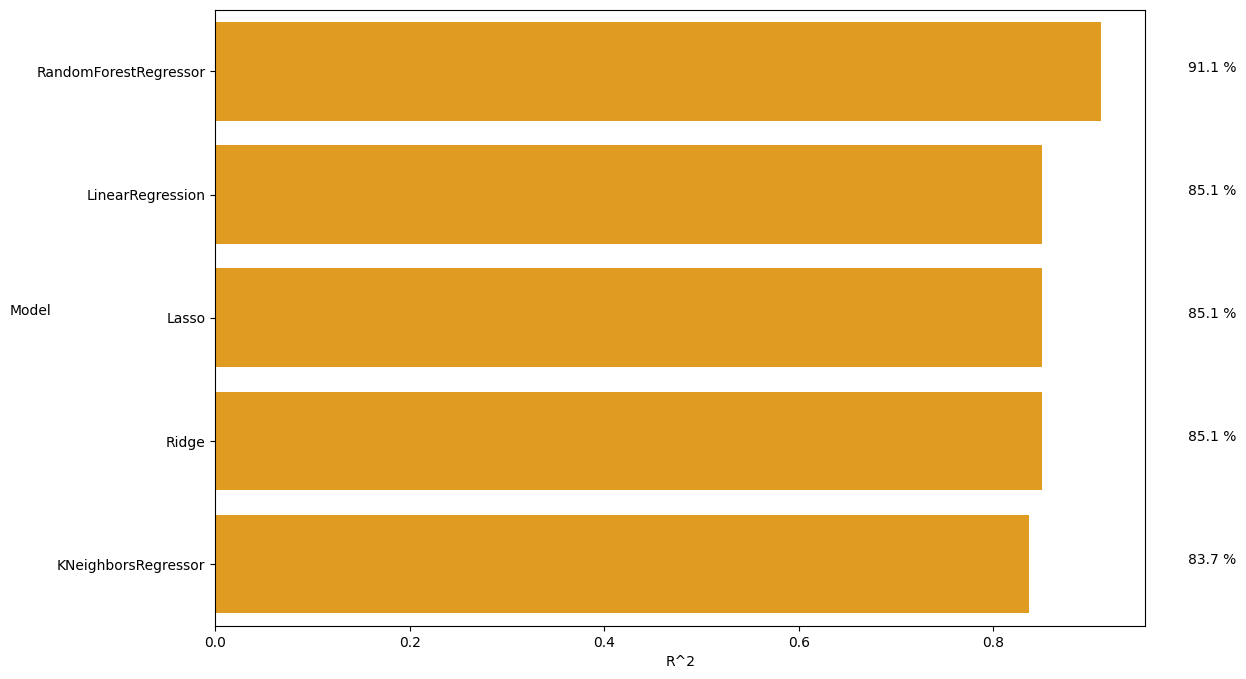

In [16]:
# visualization of model performance

fig, ax = plt.subplots(1,1,figsize=(12,8))

sns.barplot(data=initial_model_evaluation.sort_values(by="R^2", ascending=False),y="model", x="R^2", color="orange")

plt.xlabel("R^2")
plt.ylabel("Model", rotation=0)
    
for index, value in enumerate(initial_model_evaluation["R^2"].sort_values(ascending=False)):
    plt.text(1, index, str(round(value*100, 1)) + " %")
 
plt.show()


### 4. Hyper parameter tuning for selected models

**4.1 Random forest:**

In [17]:
param_grid = {"randomforestregressor__n_estimators": [80,100,120,140,160],
              "randomforestregressor__max_depth": [10,20,30,40],
              "randomforestregressor__min_samples_leaf": [1,5,10,20,30]}

model = RandomForestRegressor()
pipe = make_pipeline(preprocessing, model)
grid_rf = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid_rf.fit(X_train, y_train)

print(f"Best params: {grid_rf.best_params_}")
print(f"R^2: {grid_rf.score(X_train, y_train)}")

Best params: {'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 120}
R^2: 0.9815660990706835


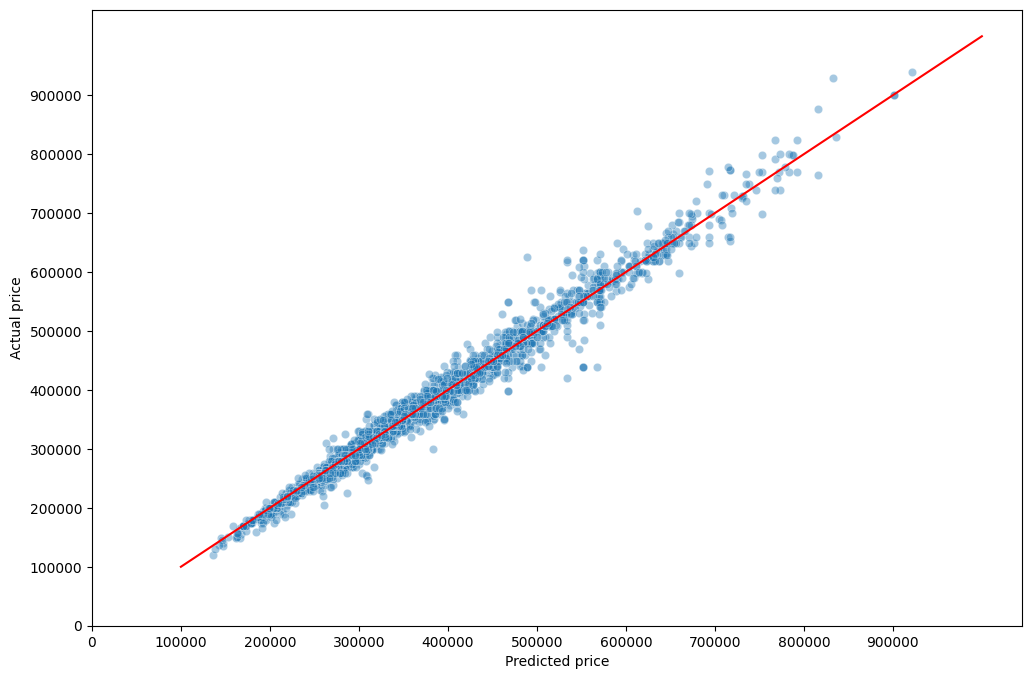

In [18]:
ax, fig = plt.subplots(1,1,figsize=(12,8))
sns.scatterplot(x=grid_rf.predict(X_train), y = y_train, alpha=0.4)

x = np.linspace(100000,1000000,2)
y = x
plt.plot(x,y, color="red")

plt.xticks(np.arange(0, 1000000, step=100000)) 
plt.yticks(np.arange(0, 1000000, step=100000)) 
plt.xlabel("Predicted price")
plt.ylabel("Actual price")

plt.show()

**4.2 KNN:**

In [19]:
param_grid = {"kneighborsregressor__n_neighbors":[1,2,3,4,5,6,7,8,9,10]}

model = KNeighborsRegressor()
pipe = make_pipeline(preprocessing, model)
grid_knn = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid_knn.fit(X_train, y_train)

print(f"Best params: {grid_knn.best_params_}")
print(f"R^2: {grid_knn.score(X_train, y_train)}")

Best params: {'kneighborsregressor__n_neighbors': 3}
R^2: 0.9349352698343708


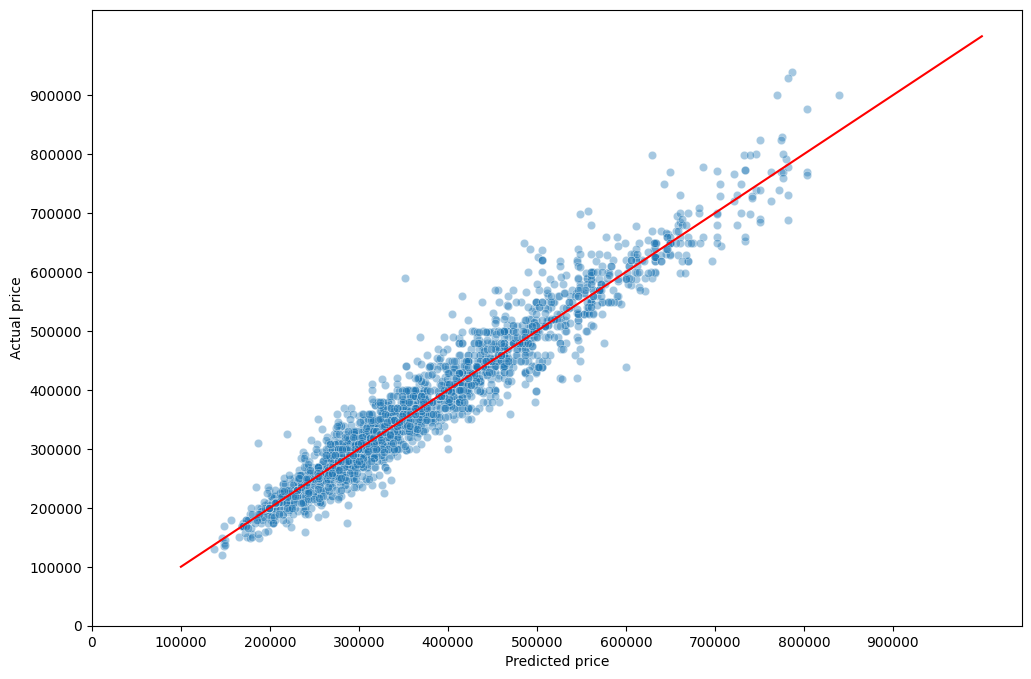

In [20]:
ax, fig = plt.subplots(1,1,figsize=(12,8))
sns.scatterplot(x=grid_knn.predict(X_train), y = y_train, alpha=0.4)

x = np.linspace(100000,1000000,2)
y = x
plt.plot(x,y, color="red")

plt.xticks(np.arange(0, 1000000, step=100000)) 
plt.yticks(np.arange(0, 1000000, step=100000)) 
plt.xlabel("Predicted price")
plt.ylabel("Actual price")

plt.show()

**4.3 Ridge:**

In [21]:
param_grid = {"ridge__alpha":[0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 5, 10]}
model = Ridge()
pipe = make_pipeline(preprocessing, model)
grid_ridge = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid_ridge.fit(X_train, y_train)

print(f"Best params: {grid_ridge.best_params_}")
print(f"R^2: {grid_ridge.score(X_train, y_train)}")

Best params: {'ridge__alpha': 0.01}
R^2: 0.8573416530870451


**4.4 Lasso:**

In [22]:
param_grid = {"lasso__alpha":[0.01, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2, 5, 10]}
model = Lasso()
pipe = make_pipeline(preprocessing, model)
grid_lasso = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid_lasso.fit(X_train, y_train)

print(f"Best params: {grid_lasso.best_params_}")
print(f"R^2: {grid_lasso.score(X_train, y_train)}")

Best params: {'lasso__alpha': 0.1}
R^2: 0.8573416535282687


**4.5 Comparison of RF and KNN:**

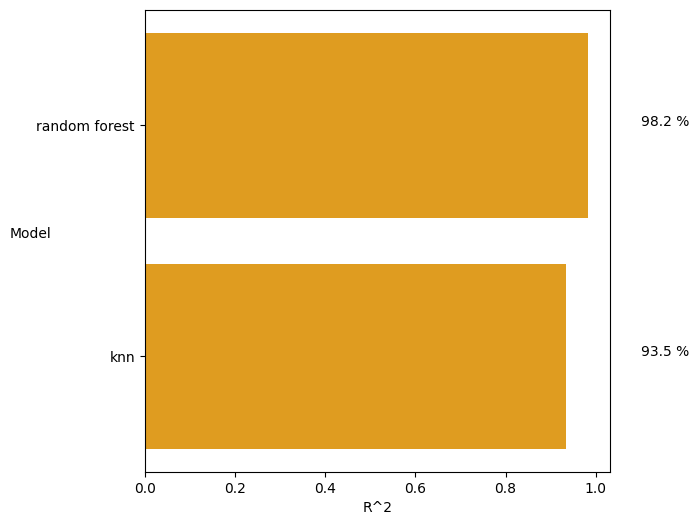

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

y = ["random forest", "knn"]
x = [grid_rf.score(X_train, y_train), grid_knn.score(X_train, y_train)]

sns.barplot(y = y, x = x, color="orange")

for index, value in enumerate(x):
    plt.text(1.1, index, str(round(value*100, 1)) + " %")
    

plt.xlabel("R^2")
plt.ylabel("Model", rotation=0)
    
plt.show()

### 5. Test data score

In [24]:
# Random forest performed better, so we'll proceed with that model
print(f"R^2: {grid_rf.score(X_test, y_test)}")

R^2: 0.9082271505293741


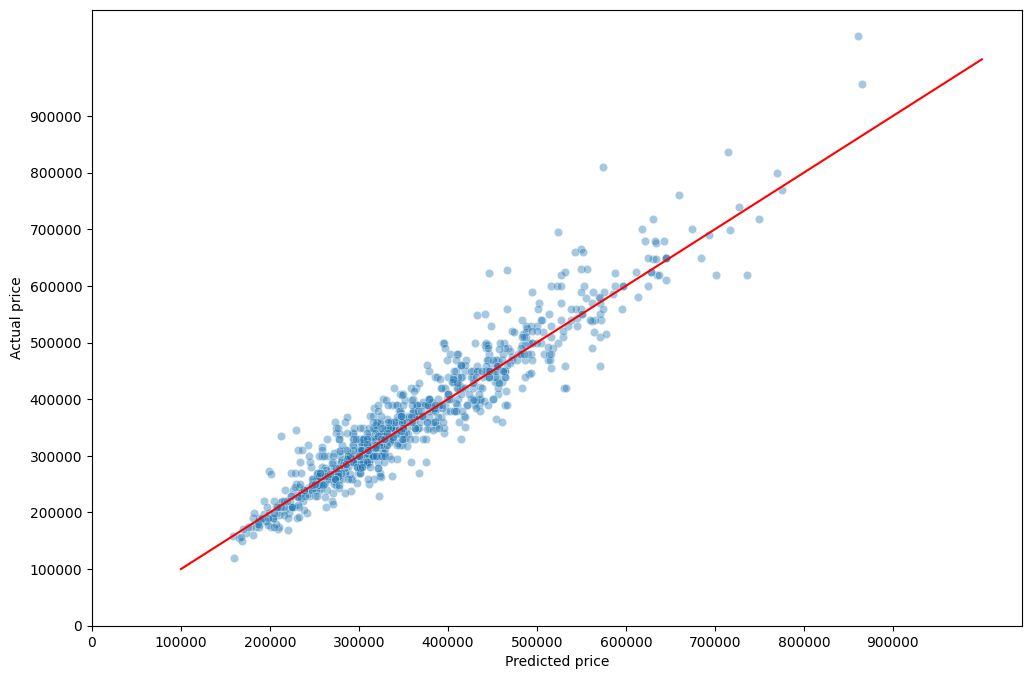

In [25]:
ax, fig = plt.subplots(1,1,figsize=(12,8))
sns.scatterplot(x=grid_rf.predict(X_test), y = y_test, alpha=0.4)

x = np.linspace(100000,1000000,2)
y = x
plt.plot(x,y, color="red")

plt.xticks(np.arange(0, 1000000, step=100000)) 
plt.yticks(np.arange(0, 1000000, step=100000)) 
plt.xlabel("Predicted price")
plt.ylabel("Actual price")

plt.show()

### Appendix: custom_imputer example

In [26]:
# In the model the custom_imputer imputes the following values for km_driven based on model_year when km_driven is missing
df.groupby("model_year")["km_driven"].mean()

model_year
2017.0    98282.912429
2018.0    76846.671070
2019.0    70181.606815
2020.0    46585.381720
2021.0    29973.345588
2022.0    21384.000000
Name: km_driven, dtype: float64

In [27]:
# Ex: some values are missing below
model_year_km_driven_example = df[["model_year", "km_driven"]]
model_year_km_driven_example.head(5)

,model_year,km_driven
0,2020.0,NaN
1,2019.0,NaN
2,2018.0,95764.0
3,2021.0,NaN
4,2018.0,60586.0


In [28]:
# These are filled below using the custom_imputer
custom_imputer("model_year").transform(model_year_km_driven_example).head(5)

,km_driven
0,46585.381720
1,70181.606815
2,95764.000000
3,29973.345588
4,60586.000000
